<h1>A Toy Wave Equation</h1>
Here we build a very small Cactus application to evolve the wave equation. The main new thing we are learning
about here is the MoL (Method of Lines) thorn. This thorn abstracts the time integration of your simulation
from the physics code.

In [1]:
%cd ~/CactusFW2

/home/sbrandt/CactusFW2


We're going through the boilerplate of making a new thorn, but we'll do some special
things along the way.

In [2]:
# Define some basic parameters describing a new thorn
thorn_pars = {
   "thorn_name" : "WaveToyET17",
   "arrangement_name" : "FunwaveUtils",
   "author" : "Steven R. Brandt",
   "email" : "sbrandt@cct.lsu.edu",
   "license" : "BSD"
 }
import os
os.environ["ARR"]=thorn_pars["arrangement_name"]
os.environ["THORN"]=thorn_pars["thorn_name"]

This next command is only needed if you want to delete the thorn you are
going to create below and start over.

In [3]:
!rm -fr arrangements/$ARR/$THORN

Next we define some functions to help us create files automatically.

In [4]:
import re
# This function does substitutes all occurances of "{name}" in input_str with values["name"]
# and returns the new string.
def replace_values(input_str,values):
    while True:
        g = re.search(r'{(\w+)}',input_str)
        if g:
            var = g.group(1)
            if var in values:
                val = values[var]
            else:
                raise Exception("Undefined: <<"+var+">>")
            start = g.start(0)
            end = start+len(g.group(0))
            input_str = input_str[0:start]+val+input_str[end:]
            continue
        break
    return input_str

# Createas a file with the given name, uses replace_values()
# to update file_contents with file_values, and writes it out.
def create_file(file_name,file_contents,file_values):
    fd = open(file_name,"w")
    file_contents = replace_values(file_contents,file_values)
    print("Over-writing file '"+file_name+"'")
    file_contents = re.sub(r'^\s+','',file_contents)
    fd.write(file_contents)
    fd.close()
    
# The equivalent of mkdir -p
def create_dir(dir):
    print("Ensuring directory '"+dir+"'")
    if not os.path.exists(dir):
        os.makedirs(dir)

<h3>Something new!</h3>
In the interface.ccl file we not only declare a grid function, but we give it scratch space of three time levels.
This gives MoL something to work with. Different time integrators will need different numbers of time levels.

Perhaps also unexpected are the rhs variables. The phi_rhs will hold the time derivative of phi, the psi_rhs will
hold the time derivative of psi. MoL will call the evolution routine repeatedly, storing the intermediate steps as
necessary for its time integration.

But wait! There's more! We also declare that we require a method called "MoLRegisterEvolvedGroup"
be provided by some thorn.

In [5]:
interface_ccl_contents = """
## Interface definitions for thorn {thorn_name}
inherits: grid
## An implementation name is required for all thorns. No
## two thorns in a configuration can implement the same
## interface.
implements: {thorn_name}

## the groups declared below can be public, private, or protected.
public:

## A group defines a set of variables that are allocated together
## and share common properties, i.e. timelevels, tags such as the
## Prolongation=None tag. The type tag can take on the values
## GF, Scalar, or Array.

## Note that the number of timelevels can be an integer parameter
## GF stands for "Grid Function" and refers to a distributed array
## data structure.
#cctk_real force_group type=GF timelevels=3 tags='Prolongation="None"'
#{
#  force1, force2
#}

## Scalars are single variables that are available on all processors.
#cctk_real scalar_group type=SCALAR 
#{
#  scalar1, scalar2
#}

cctk_real evol_group type=GF timelevels=3
{
  psi, phi
}
cctk_real rhs_group type=GF 
{
  psi_rhs, phi_rhs
}

#----------------------------------------------------
#   MoL functions to register variables
#----------------------------------------------------

CCTK_INT FUNCTION MoLRegisterEvolvedGroup(CCTK_INT IN EvolvedIndex, CCTK_INT IN RHSIndex)
REQUIRES FUNCTION MoLRegisterEvolvedGroup

"""

<h3>Something new!</h3>
We schedule three routines. The initial and evolution routines are unsurprising. The register method, however, is
new. This is the place where we will tell MoL what variables we are evolving.

In [6]:
schedule_ccl_contents = """
## Schedule definitions for thorn {thorn_name}

## There won't be any storage allocated for a group
## unless a corresponding storage declaration exists
## for it in the schedule file. In square brackets,
## we specify the number of storage levels to allocate.
## These commented examples correspond to the commented
## examples in the interface file above.
# storage: force_group[3]
# storage: scalar_group

## Schedule a function defined in this thorn to run at the beginning
## of the simulation. The minimum you need to specify for a schedule
## item is what language it's written in. Choices are: C (which includes
## C++) and Fortran (which means Fortran90).
#SCHEDULE init_function at CCTK_INIT
#{
#  LANG: C
#}"Do some initial stuff"

storage: evol_group[3], rhs_group

SCHEDULE init_wave_toy in CCTK_INITIAL
{
  LANG: C
} "initialize data"

SCHEDULE evolve_wave_toy in MoL_CalcRHS
{
  LANG: C
} "evolve data"

schedule wave_toy_registervars in MoL_Register
{
  LANG: C
}"Register funwave variables for MoL"

"""

In [7]:
param_ccl_contents = """
## Parameter definitions for thorn {thorn_name}
## There are five types of parameters: int, real, keyword, string, and boolean.
## The comments provide prototypes of each.
#
#CCTK_INT one_to_five "This integer parameter goes from 1 to 5"
#{
#  1:5 :: "Another comment"
#} 3 # This is the default value
#
#CCTK_REAL from_2p5_to_3p8e4 "This integer parameter goes from 2.5 to 3.8e4"
#{
#  2.5:3.8e4 :: "Another comment"
#} 4.4e3 # This is the default value
#
## This keyword example defines the parameter wavemaker_type and 8 possible values.
#CCTK_KEYWORD wavemaker_type "types of wave makers"
#{
#  "ini_rec" :: "initial rectangular hump, need xc,yc and wid"
#  "lef_sol" :: "initial solitary wave, WKN B solution, need amp, dep"
#  "ini_oth" :: "other initial distribution specified by users"
#  "wk_reg" :: "Wei and Kirby 1999 internal wave maker, need xc_wk, tperiod, amp_wk, dep_wk, theta_wk, and time_ramp (factor of period)"
#  "wk_irr" :: "Wei and Kirby 1999 TMA spectrum wavemaker, need xc_wk, dep_wk, time_ramp, delta_wk, freqpeak, freqmin, freqmax, hmo, gammatma, theta-peak"
#  "wk_time_series" :: "fft a time series to get each wave component and then use Wei and Kirby's ( 1999) wavemaker. Need input wavecompfile (including 3 columns:   per,amp,pha) and numwavecomp, peakperiod, dep_wk, xc_wk, ywidth_wk"
#  "ini_gau" :: "initial Gaussian hump, need amp, xc, yc, and wid"
#  "ini_sol" :: "initial solitary wave, xwavemaker"
#}"wk_reg" # This is the default value
#
#CCTK_STRING a_string_par "a comment"
#{
#  .* :: "This is a perl 5 regular expression defining what the string may contain"
#} "blah blah blah" # This is the default value
#
#BOOLEAN a_boolean_par "a comment"
#{
#} true


"""

In [8]:
configuration_ccl_contents = """
# Configuration definitions for thorn {thorn_name}
## You should not need include "mpi.h", but if you
## do, you will need this next line.
# REQUIRES MPI
# REQUIRES HDF5
"""

In [9]:
makefile_contents = """
# Main make.code.defn file for thorn {thorn_name}

# Source files in this directory
SRCS = init.cc evolve.cc molregister.cc

# Subdirectories containing source files
SUBDIRS =
"""

In [10]:
readme_contents = """
Author(s)    : {author} <{email}>
Maintainer(s): {author} <{email}>
Licence      : {license}
--------------------------------------------------------------------------

1. Purpose

not documented
"""

In [11]:
import os

# This function will create a complete thorn
def create_thorn():
  # Create the thorn directory inside the Cactus source tree
  arrangement_dir = "arrangements/"+thorn_pars["arrangement_name"]
  thorn_dir = arrangement_dir + "/" + thorn_pars["thorn_name"]
  create_dir(thorn_dir)

  # Create basic ccl files needed by Cactus
  schedule_ccl = thorn_dir+"/schedule.ccl"
  interface_ccl = thorn_dir+"/interface.ccl"
  param_ccl = thorn_dir+"/param.ccl"
  configuration_ccl = thorn_dir+"/configuration.ccl"
  create_file(schedule_ccl,schedule_ccl_contents,thorn_pars)
  create_file(interface_ccl,interface_ccl_contents,thorn_pars)
  create_file(param_ccl,param_ccl_contents,thorn_pars)
  create_file(configuration_ccl,configuration_ccl_contents,thorn_pars)

  # Create the source directory and first makefile
  src_dir = thorn_dir+"/src"
  create_dir(src_dir)
  create_file(src_dir+"/make.code.defn",makefile_contents,thorn_pars)

  # Other dirs and files not strictly needed
  # for compiling and running Cactus.
  create_file(thorn_dir+"/README",readme_contents,thorn_pars)
  
  test_dir = thorn_dir+"/test"
  create_dir(test_dir)
  par_dir = thorn_dir+"/par"
  create_dir(par_dir)
  doc_dir = thorn_dir+"/doc"
  create_dir(doc_dir)

In [12]:
create_thorn()

Ensuring directory 'arrangements/FunwaveUtils/WaveToyET17'
Over-writing file 'arrangements/FunwaveUtils/WaveToyET17/schedule.ccl'
Over-writing file 'arrangements/FunwaveUtils/WaveToyET17/interface.ccl'
Over-writing file 'arrangements/FunwaveUtils/WaveToyET17/param.ccl'
Over-writing file 'arrangements/FunwaveUtils/WaveToyET17/configuration.ccl'
Ensuring directory 'arrangements/FunwaveUtils/WaveToyET17/src'
Over-writing file 'arrangements/FunwaveUtils/WaveToyET17/src/make.code.defn'
Over-writing file 'arrangements/FunwaveUtils/WaveToyET17/README'
Ensuring directory 'arrangements/FunwaveUtils/WaveToyET17/test'
Ensuring directory 'arrangements/FunwaveUtils/WaveToyET17/par'
Ensuring directory 'arrangements/FunwaveUtils/WaveToyET17/doc'


In [13]:
my_thorns_contents="""
# ./configs/sim/ThornList
# This file was automatically generated using the GetComponents script.

!CRL_VERSION = 2.0


# Component list: funwave.th

!DEFINE ROOT = CactusFW2
!DEFINE ARR = $ROOT/arrangements
!DEFINE ET_RELEASE = trunk
!DEFINE FW_RELEASE = FW_2014_05

#Cactus Flesh
!TARGET   = $ROOT
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactus.git
!NAME     = flesh
!CHECKOUT = CONTRIBUTORS COPYRIGHT doc lib Makefile src

!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/stevenrbrandt/cajunwave.git
!REPO_PATH= $2
# Old version
#!AUTH_URL = https://svn.cct.lsu.edu/repos/projects/ngchc/code/branches/$FW_RELEASE/$1/$2
#!URL = https://svn.cct.lsu.edu/repos/projects/ngchc/code/branches/$FW_RELEASE/$2
#!URL = https://svn.cct.lsu.edu/repos/projects/ngchc/code/CactusCoastal/$2
!CHECKOUT =
CactusCoastal/Funwave
CactusCoastal/FunwaveMesh
CactusCoastal/FunwaveCoord
CactusCoastal/Tridiagonal
CactusCoastal/Tridiagonal2

# CactusBase thorns
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactusbase.git
!REPO_PATH= $2
!CHECKOUT =
CactusBase/Boundary
CactusBase/CartGrid3D
CactusBase/CoordBase
CactusBase/Fortran
CactusBase/InitBase
CactusBase/IOASCII
CactusBase/IOBasic
CactusBase/IOUtil
CactusBase/SymBase
CactusBase/Time
#
# CactusNumerical thorns
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactusnumerical.git
!REPO_PATH= $2
!CHECKOUT =
!CHECKOUT =
CactusNumerical/MoL
CactusNumerical/LocalInterp

CactusNumerical/Dissipation
CactusNumerical/SpaceMask
CactusNumerical/SphericalSurface
CactusNumerical/LocalReduce
CactusNumerical/InterpToArray

!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactusutils.git
!REPO_PATH= $2
!CHECKOUT = CactusUtils/Accelerator CactusUtils/OpenCLRunTime
CactusUtils/NaNChecker
CactusUtils/Vectors
CactusUtils/SystemTopology

# Carpet, the AMR driver
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/eschnett/carpet.git
!REPO_PATH= $2
!CHECKOUT = Carpet/doc
Carpet/Carpet
Carpet/CarpetEvolutionMask
Carpet/CarpetIOASCII
Carpet/CarpetIOBasic
Carpet/CarpetIOHDF5
Carpet/CarpetIOScalar
#Carpet/CarpetIntegrateTest
Carpet/CarpetInterp
Carpet/CarpetInterp2
Carpet/CarpetLib
Carpet/CarpetMask
#Carpet/CarpetProlongateTest
Carpet/CarpetReduce
Carpet/CarpetRegrid
Carpet/CarpetRegrid2
#Carpet/CarpetRegridTest
Carpet/CarpetSlab
Carpet/CarpetTracker
Carpet/CycleClock
#Carpet/HighOrderWaveTest
Carpet/LoopControl
#Carpet/ReductionTest
#Carpet/ReductionTest2
#Carpet/ReductionTest3
#Carpet/RegridSyncTest
Carpet/TestCarpetGridInfo
Carpet/TestLoopControl
Carpet/Timers

# Additional Cactus thorns
!TARGET   = $ARR
!TYPE     = svn
!URL      = https://svn.cactuscode.org/projects/$1/$2/trunk
!CHECKOUT = ExternalLibraries/OpenBLAS ExternalLibraries/OpenCL ExternalLibraries/pciutils ExternalLibraries/PETSc
ExternalLibraries/MPI
ExternalLibraries/HDF5
ExternalLibraries/zlib
ExternalLibraries/hwloc

# Simulation Factory
!TARGET   = $ROOT/simfactory
!TYPE     = git
!URL      = https://bitbucket.org/simfactory/simfactory2.git
!NAME     = simfactory2
!CHECKOUT = README.md README_FIRST.txt bin doc etc lib mdb

# Various thorns from LSU
#!TARGET   = $ARR
#!TYPE     = git
#!URL      = https://bitbucket.org/einsteintoolkit/archivedthorns-vectors.git
#!REPO_PATH= $2
#!CHECKOUT =
#LSUThorns/Vectors
#LSUThorns/QuasiLocalMeasures
#LSUThorns/SummationByParts
#LSUThorns/Prolong

#Roland/MapPoints
#Tutorial/BadWaveMoL
#Tutorial/BasicWave
#Tutorial/BasicWave2
#Tutorial/BasicWave3

# Various thorns from the AEI
# Numerical
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/numerical.git
!REPO_PATH= $2
!CHECKOUT =
#AEIThorns/ADMMass
AEIThorns/AEILocalInterp
#AEIThorns/PunctureTracker
#AEIThorns/SystemStatistics
#AEIThorns/Trigger
{arrangement_name}/{thorn_name}"""
create_file("my_thorns.th",my_thorns_contents,thorn_pars)

Over-writing file 'my_thorns.th'


<h3>Something new!</h3>
Here we create the source code. The initialization, evolution, and molregister functions.

In [14]:
src_dir = "arrangements/"+thorn_pars["arrangement_name"]+"/"+thorn_pars["thorn_name"]+"/src"

init_cc_src = """
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>
#include <math.h>

void init_wave_toy(CCTK_ARGUMENTS) {
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
  for(int k=0;k<cctk_lsh[2];k++) {
      for(int j=0;j<cctk_lsh[1];j++) {
          for(int i=0;i<cctk_lsh[0];i++) {
              int cc = CCTK_GFINDEX3D(cctkGH,i,j,k);
              CCTK_REAL xx = x[cc] - 5.0;
              CCTK_REAL yy = y[cc] - 5.0;
              psi[cc] = exp(-xx*xx-yy*yy);
              phi[cc] = 0;
          }
      }
  }
}
"""
create_file(src_dir+"/init.cc",init_cc_src,{})

Over-writing file 'arrangements/FunwaveUtils/WaveToyET17/src/init.cc'


In [15]:
evolve_cc_src = """
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>
#include <math.h>
#include <assert.h>

void evolve_wave_toy(CCTK_ARGUMENTS) {
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
  for(int k=0;k<cctk_lsh[2];k++) {
      for(int j=1;j<cctk_lsh[1]-1;j++) {
          for(int i=1;i<cctk_lsh[0]-1;i++) {
              int cc = CCTK_GFINDEX3D(cctkGH,i,j,k);
              int im1 = CCTK_GFINDEX3D(cctkGH,i-1,j,k);
              int ip1 = CCTK_GFINDEX3D(cctkGH,i+1,j,k);
              int jm1 = CCTK_GFINDEX3D(cctkGH,i,j-1,k);
              int jp1 = CCTK_GFINDEX3D(cctkGH,i,j+1,k);
              CCTK_REAL dx = CCTK_DELTA_SPACE(0);
              CCTK_REAL dy = CCTK_DELTA_SPACE(1);
              psi_rhs[cc] = phi[cc];
              CCTK_REAL divx = (psi[ip1] + psi[im1] - 2*psi[cc])/(dx*dx);
              CCTK_REAL divy = (psi[jp1] + psi[jm1] - 2*psi[cc])/(dy*dy);
              phi_rhs[cc] = divx + divy;
          }
      }
  }
}
"""
create_file(src_dir+"/evolve.cc",evolve_cc_src,{})

Over-writing file 'arrangements/FunwaveUtils/WaveToyET17/src/evolve.cc'


In [16]:
molregister_cc_src = """
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>

extern "C" void wave_toy_registervars (CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
  CCTK_INT ierr = 0, group, rhs;

  // Look up the group index of the evol_group
  group = CCTK_GroupIndex ("{thorn_name}::evol_group");
  
  // Look up the group index of the rhs_group
  rhs = CCTK_GroupIndex ("{thorn_name}::rhs_group");

  if (CCTK_IsFunctionAliased ("MoLRegisterEvolvedGroup"))
  {
    // *** KEY STEP! *** Tell MoL what we variables
    // we are evolving and what the rhs variables are.
    ierr += MoLRegisterEvolvedGroup (group, rhs);
  }
  else
  {
    CCTK_WARN (0, "MoL function not aliased !");
    ierr++;
  }

  if (ierr)
    CCTK_WARN (0, "Problems registering with MoL !");
}

"""
create_file(src_dir+"/molregister.cc",molregister_cc_src,thorn_pars)

Over-writing file 'arrangements/FunwaveUtils/WaveToyET17/src/molregister.cc'


In [17]:
!time ./simfactory/bin/sim build -j 2 --thornlist=./my_thorns.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
Parsing interface files...
   AEILocalInterp
           Implements: AEILocalInterp
           0 Public, 0 Protected, 0 Private variable groups
   Boundary
           Implements: boundary
           0 Public, 0 Protected, 0 Private variable groups
   Cactus
           Implements: Cactus
           0 Public, 0 Protected, 0 Private variable groups
   Carpet
           Implements: Driver
           0 Public, 0 Protected, 6 Private variable groups
   CarpetEvolutionMask
           Implements: CarpetEvolutionMask
           2 Public, 0 Protected, 0 Private variable groups
   CarpetIOASCII
           Implements: IOASCII
           0 Public, 0 Protected, 3 Private variable groups
   CarpetIOBasic
           Implements: IOBasic
           Inherits:  IO 
           0 Public, 0 Protected, 3 Privat

          0 Global, 59 Restricted, 2 Private parameters
   InitBase
          0 Global, 1 Restricted, 0 Private parameters
   InterpToArray
          0 Global, 93 Restricted, 0 Private parameters
   LocalInterp
          0 Global, 0 Restricted, 0 Private parameters
   LocalReduce
          0 Global, 0 Restricted, 0 Private parameters
   LoopControl
          0 Global, 0 Restricted, 20 Private parameters
   MPI
          0 Global, 0 Restricted, 0 Private parameters
   MoL
          0 Global, 9 Restricted, 26 Private parameters
   NaNChecker
          0 Global, 0 Restricted, 11 Private parameters
   SpaceMask
          0 Global, 1 Restricted, 0 Private parameters
   SphericalSurface
          0 Global, 15 Restricted, 9 Private parameters
   SymBase
          0 Global, 0 Restricted, 1 Private parameters
   SystemTopology
          0 Global, 0 Restricted, 2 Private parameters
   TestCarpetGridInfo
          0 Global, 0 Restricted, 2 Private parameters
   TestLoopControl
          0 Global,

Checking status of thorn TestCarpetGridInfo
Creating cactus_sim in /home/sbrandt/CactusFW2/exe from AEIThorns/AEILocalInterp CactusBase/Boundary Carpet/Carpet Carpet/CarpetEvolutionMask Carpet/CarpetIOASCII Carpet/CarpetIOBasic Carpet/CarpetIOHDF5 Carpet/CarpetIOScalar Carpet/CarpetInterp Carpet/CarpetInterp2 Carpet/CarpetLib Carpet/CarpetMask Carpet/CarpetReduce Carpet/CarpetRegrid Carpet/CarpetRegrid2 Carpet/CarpetSlab Carpet/CarpetTracker CactusBase/CartGrid3D CactusBase/CoordBase Carpet/CycleClock CactusNumerical/Dissipation CactusBase/Fortran CactusCoastal/Funwave CactusCoastal/FunwaveCoord CactusCoastal/FunwaveMesh ExternalLibraries/HDF5 CactusBase/IOASCII CactusBase/IOBasic CactusBase/IOUtil CactusBase/InitBase CactusNumerical/InterpToArray CactusNumerical/LocalInterp CactusNumerical/LocalReduce Carpet/LoopControl ExternalLibraries/MPI CactusNumerical/MoL CactusUtils/NaNChecker CactusNumerical/SpaceMask CactusNumerical/SphericalSurface CactusBase/SymBase CactusUtils/SystemTopolo

In [18]:
# A minimal par file....

wave_toy_par_src = """
ActiveThorns = "{thorn_name} coordbase carpet cartgrid3d MoL"

Cactus::cctk_itlast = 250

# the output dir will be named after the parameter file name
IO::out_dir = $parfile

# The set of parameters required to specify the grid...
Carpet::domain_from_coordbase = "yes"
CartGrid3D::type = "coordbase"
CartGrid3D::avoid_origin = "no"
CoordBase::domainsize = "minmax"
CoordBase::spacing    = "gridspacing"
CoordBase::xmin =  0
CoordBase::xmax =  30
CoordBase::ymin =  0
CoordBase::ymax =  30
CoordBase::zmin =  0.0
CoordBase::zmax =  0.0
CoordBase::dx   =  0.25
CoordBase::dy   =  0.25

# Because we're doing a 2D code...
CoordBase::boundary_size_z_lower     = 0
CoordBase::boundary_size_z_upper     = 0
CoordBase::boundary_shiftout_z_lower = 1
CoordBase::boundary_shiftout_z_upper = 1

# The time integration scheme...
MoL::ODE_Method = "RK3"

# The next section is required if you want some kind of confirmation
# on the console that your code is actually doing anything...
ActiveThorns = "CarpetIOBasic IOUtil CarpetReduce SymBase"
IO::out_fileinfo="none"
IOBasic::outInfo_every = 1
IOBasic::outInfo_vars = "{thorn_name}::phi {thorn_name}::psi"

# Get some data!
ActiveThorns = "CarpetIOASCII"
CarpetIOASCII::compact_format = false
IOASCII::out2D_every = 25
IOASCII::out2D_xyplane_z = 0
IOASCII::out2D_vars = "{thorn_name}::psi {thorn_name}::phi"
IOASCII::out2D_xz = "no"
IOASCII::out2D_yz = "no"
IOASCII::output_ghost_points = "no"

# Taking too big a time step can lead to unstable evolution.
# You can control that with dtfac and thorn Time.
ActiveThorns = "Time"
Time::dtfac = .2
"""
create_file("wave_toy.par",wave_toy_par_src,thorn_pars)

Over-writing file 'wave_toy.par'


In [19]:
!rm -fr ../simulations/wave_toy
!./simfactory/bin/sim create-run wave_toy.par --procs=1 --num-threads=1

Parameter file: /home/sbrandt/CactusFW2/wave_toy.par
Skeleton Created
Job directory: "/home/sbrandt/simulations/wave_toy"
Executable: "/home/sbrandt/CactusFW2/exe/cactus_sim"
Option list: "/home/sbrandt/simulations/wave_toy/SIMFACTORY/cfg/OptionList"
Submit script: "/home/sbrandt/simulations/wave_toy/SIMFACTORY/run/SubmitScript"
Run script: "/home/sbrandt/simulations/wave_toy/SIMFACTORY/run/RunScript"
Parameter file: "/home/sbrandt/simulations/wave_toy/SIMFACTORY/par/wave_toy.par"
Simulation name: wave_toy
Assigned restart id: 0 
Running simulation wave_toy
Preparing:
+ set -e
+ echo Checking:
Checking:
+ pwd
/home/sbrandt/simulations/wave_toy/output-0000
+ hostname
melete05.cct.lsu.edu
+ date
Mon Jul 31 13:02:12 CDT 2017
+ echo Environment:
Environment:
+ export CACTUS_NUM_PROCS=1
+ CACTUS_NUM_PROCS=1
+ export CACTUS_NUM_THREADS=1
+ CACTUS_NUM_THREADS=1
+ export GMON_OUT_PREFIX=gmon.out
+ GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=1
+ OMP_NUM_THREADS=1
+ echo Starting:
Starting

INFO (CycleClock): Calibrated CycleClock: 0.454547 ns per clock tick (2.19999 GHz)
INFO (Vectors): Using vector size 1 for architecture scalar (no vectorisation, 64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
MoL: Generalized time integration.
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 2D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 3D ASCII I/O pro

       38     1.900 |   -0.2337679    0.2021617 |   -0.3926842    0.2363856
       39     1.950 |   -0.2218747    0.2012299 |   -0.3877370    0.2386950
---------------------------------------------------------------------------
Iteration      Time |          WAVETOYET17::psi |          WAVETOYET17::phi
                    |      minimum      maximum |      minimum      maximum
---------------------------------------------------------------------------
       40     2.000 |   -0.2113639    0.1996998 |   -0.3845668    0.2371067
       41     2.050 |   -0.2021501    0.1969922 |   -0.3767959    0.2323288
       42     2.100 |   -0.1943005    0.1949926 |   -0.3707725    0.2250242
       43     2.150 |   -0.1871954    0.1941830 |   -0.3695076    0.2157991
       44     2.200 |   -0.1811315    0.1919436 |   -0.3637509    0.2051961
       45     2.250 |   -0.1753969    0.1892964 |   -0.3563209    0.1936904
       46     2.300 |   -0.1704707    0.1884530 |   -0.3536325    0.1816882
       47   

      126     6.300 |   -0.2043194    0.1201796 |   -0.3779180    0.2566584
      127     6.350 |   -0.2110435    0.1196850 |   -0.3705158    0.2562290
      128     6.400 |   -0.2232621    0.1197439 |   -0.3591317    0.2553437
      129     6.450 |   -0.2345385    0.1190077 |   -0.3418924    0.2550628
      130     6.500 |   -0.2447924    0.1182272 |   -0.3188122    0.2547708
      131     6.550 |   -0.2539430    0.1181958 |   -0.2976396    0.2532538
      132     6.600 |   -0.2619086    0.1179200 |   -0.3000665    0.2536605
      133     6.650 |   -0.2686066    0.1171213 |   -0.3009617    0.2515419
      134     6.700 |   -0.2740360    0.1165259 |   -0.2984011    0.2523630
      135     6.750 |   -0.2793025    0.1166880 |   -0.2940767    0.2500674
      136     6.800 |   -0.2822657    0.1160498 |   -0.2974743    0.2509075
      137     6.850 |   -0.2828458    0.1153010 |   -0.2974388    0.2490522
      138     6.900 |   -0.2809893    0.1151879 |   -0.2939048    0.2490225
      139   

      224    11.200 |   -0.1715325    0.1497427 |   -0.2164994    0.2841652
      225    11.250 |   -0.1713794    0.1476933 |   -0.2201323    0.2863012
      226    11.300 |   -0.1726036    0.1482539 |   -0.2214803    0.2904581
      227    11.350 |   -0.1728534    0.1489435 |   -0.2204477    0.2913967
      228    11.400 |   -0.1720698    0.1484874 |   -0.2169748    0.2890722
      229    11.450 |   -0.1702045    0.1469042 |   -0.2154069    0.2835002
      230    11.500 |   -0.1692487    0.1456492 |   -0.2183395    0.2803504
      231    11.550 |   -0.1696153    0.1469069 |   -0.2189589    0.2853398
      232    11.600 |   -0.1705268    0.1470015 |   -0.2171761    0.2877600
      233    11.650 |   -0.1704592    0.1459438 |   -0.2129388    0.2869758
      234    11.700 |   -0.1693575    0.1446135 |   -0.2139021    0.2829729
      235    11.750 |   -0.1672965    0.1445291 |   -0.2161438    0.2777227
      236    11.800 |   -0.1669784    0.1452201 |   -0.2160501    0.2792102
      237   

In [20]:
# This cell enables inline plotting in the notebook
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# https://matplotlib.org/examples/color/colormaps_reference.html
cmap = cm.prism

In [21]:
file_data = np.genfromtxt("../simulations/wave_toy/output-0000/wave_toy/psi.xy.asc")

sets= [   0.   25.   50.   75.  100.  125.  150.  175.  200.  225.  250.]
time= 0.0
min/max= 0.0 1.0


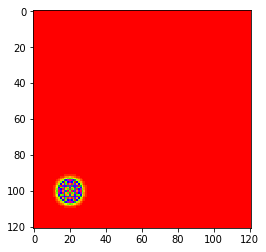

time= 25.0
min/max= -0.245488345688 0.236825049851


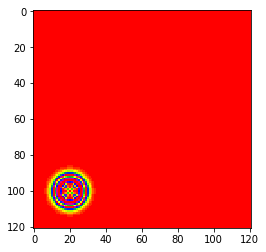

time= 50.0
min/max= -0.154033365164 0.182633481829


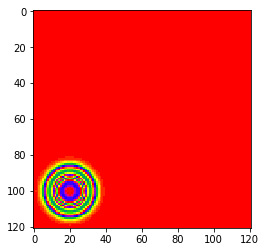

time= 75.0
min/max= -0.10569862376 0.153407032713


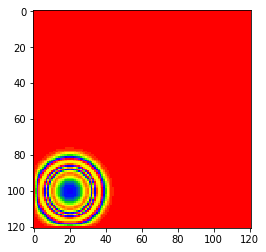

time= 100.0
min/max= -0.144224202634 0.134552960331


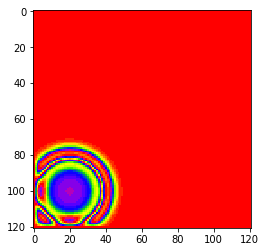

time= 125.0
min/max= -0.199506702817 0.121023330873


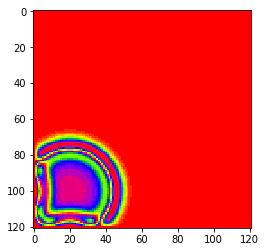

time= 150.0
min/max= -0.229575071116 0.110714884067


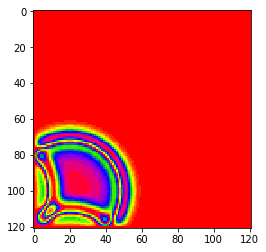

time= 175.0
min/max= -0.200784801505 0.210984031467


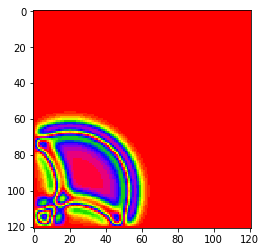

time= 200.0
min/max= -0.18540362708 0.161917720306


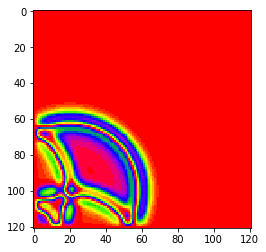

time= 225.0
min/max= -0.17137942871 0.147693346001


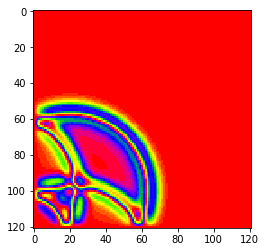

time= 250.0
min/max= -0.1642498645 0.141003971065


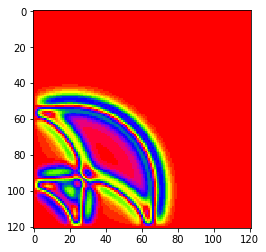

In [22]:
sets = np.unique(file_data[:,0])
width = 8
height = 4
print("sets=",sets)
mn, mx = np.min(file_data[:,12]),np.max(file_data[:,12])
#mn, mx = 0,1
for which in sets:
    g = file_data[file_data[:,0]==which,:]
    print("time=",which)
    x = g[:,5]
    y = g[:,6]
    z = g[:,12]
    zi = z.reshape(len(np.unique(y)),len(np.unique(x)))
    print('min/max=',np.min(zi),np.max(zi))
    plt.figure(figsize=(width, height))
    plt.imshow(zi[::-1,:],cmap,clim=(mn,mx))
    plt.show()

<h3>Question</h3>: Does the above simulation work properly if we use 2 procs? Why or why not? Try it.

In [23]:
schedule_ccl_contents = """
## Schedule definitions for thorn {thorn_name}

## There won't be any storage allocated for a group
## unless a corresponding storage declaration exists
## for it in the schedule file. In square brackets,
## we specify the number of storage levels to allocate.
## These commented examples correspond to the commented
## examples in the interface file above.
# storage: force_group[3]
# storage: scalar_group

## Schedule a function defined in this thorn to run at the beginning
## of the simulation. The minimum you need to specify for a schedule
## item is what language it's written in. Choices are: C (which includes
## C++) and Fortran (which means Fortran90).
#SCHEDULE init_function at CCTK_INIT
#{
#  LANG: C
#}"Do some initial stuff"

storage: evol_group[3], rhs_group

SCHEDULE init_wave_toy in CCTK_INITIAL
{
  LANG: C
} "initialize data"

SCHEDULE evolve_wave_toy in MoL_CalcRHS
{
  LANG: C
  SYNC: {thorn_name}::evol_group
  SYNC: {thorn_name}::rhs_group
} "evolve data"

schedule wave_toy_registervars in MoL_Register
{
  LANG: C
}"Register funwave variables for MoL"

"""
thorn_dir = "arrangements/"+thorn_pars["arrangement_name"]+"/"+thorn_pars["thorn_name"]
create_file(thorn_dir+"/schedule.ccl",schedule_ccl_contents,thorn_pars)

Over-writing file 'arrangements/FunwaveUtils/WaveToyET17/schedule.ccl'


In [24]:
!time ./simfactory/bin/sim build -j 2 --thornlist=./my_thorns.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
Parsing interface files...
   AEILocalInterp
           Implements: AEILocalInterp
           0 Public, 0 Protected, 0 Private variable groups
   Boundary
           Implements: boundary
           0 Public, 0 Protected, 0 Private variable groups
   Cactus
           Implements: Cactus
           0 Public, 0 Protected, 0 Private variable groups
   Carpet
           Implements: Driver
           0 Public, 0 Protected, 6 Private variable groups
   CarpetEvolutionMask
           Implements: CarpetEvolutionMask
           2 Public, 0 Protected, 0 Private variable groups
   CarpetIOASCII
           Implements: IOASCII
           0 Public, 0 Protected, 3 Private variable groups
   CarpetIOBasic
           Implements: IOBasic
           Inherits:  IO 
           0 Public, 0 Protected, 3 Privat

          0 Global, 0 Restricted, 13 Private parameters
   IOUtil
          0 Global, 59 Restricted, 2 Private parameters
   InitBase
          0 Global, 1 Restricted, 0 Private parameters
   InterpToArray
          0 Global, 93 Restricted, 0 Private parameters
   LocalInterp
          0 Global, 0 Restricted, 0 Private parameters
   LocalReduce
          0 Global, 0 Restricted, 0 Private parameters
   LoopControl
          0 Global, 0 Restricted, 20 Private parameters
   MPI
          0 Global, 0 Restricted, 0 Private parameters
   MoL
          0 Global, 9 Restricted, 26 Private parameters
   NaNChecker
          0 Global, 0 Restricted, 11 Private parameters
   SpaceMask
          0 Global, 1 Restricted, 0 Private parameters
   SphericalSurface
          0 Global, 15 Restricted, 9 Private parameters
   SymBase
          0 Global, 0 Restricted, 1 Private parameters
   SystemTopology
          0 Global, 0 Restricted, 2 Private parameters
   TestCarpetGridInfo
          0 Global, 0 Restr

Done creating cactus_sim.
All done !
Building utilities for sim
Building utilities for sim
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOASCII/src/util/carpet2xgraph.c
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5toascii_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5tobinary_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_recombiner.cc
Copying gif2h5 from /usr/bin/gif2h5 to /home/sbrandt/CactusFW2/exe/sim
Copying h52gif from /usr/bin/h52gif to /home/sbrandt/CactusFW2/exe/sim
Copying h5copy from /usr/bin/h5copy to /home/sbrandt/CactusFW2/exe/sim
Copying h5debug from /usr/bin/h5debug to /home/sbrandt/CactusFW2/exe/sim
Copying h5diff from /usr/bin/h5diff to /home/sbrandt/CactusFW2/exe/sim
Copying h5dump from /usr/bin/h5dump to /home/sbrandt/CactusFW2/exe/sim
Copyi

In [25]:
!rm -fr ../simulations/wave_toy
!./simfactory/bin/sim create-run wave_toy.par --procs=2 --num-threads=1

Parameter file: /home/sbrandt/CactusFW2/wave_toy.par
Skeleton Created
Job directory: "/home/sbrandt/simulations/wave_toy"
Executable: "/home/sbrandt/CactusFW2/exe/cactus_sim"
Option list: "/home/sbrandt/simulations/wave_toy/SIMFACTORY/cfg/OptionList"
Submit script: "/home/sbrandt/simulations/wave_toy/SIMFACTORY/run/SubmitScript"
Run script: "/home/sbrandt/simulations/wave_toy/SIMFACTORY/run/RunScript"
Parameter file: "/home/sbrandt/simulations/wave_toy/SIMFACTORY/par/wave_toy.par"
Simulation name: wave_toy
Assigned restart id: 0 
Running simulation wave_toy
Preparing:
+ set -e
+ echo Checking:
Checking:
+ pwd
/home/sbrandt/simulations/wave_toy/output-0000
+ hostname
melete05.cct.lsu.edu
+ date
Mon Jul 31 13:04:26 CDT 2017
+ echo Environment:
Environment:
+ export CACTUS_NUM_PROCS=2
+ CACTUS_NUM_PROCS=2
+ export CACTUS_NUM_THREADS=1
+ CACTUS_NUM_THREADS=1
+ export GMON_OUT_PREFIX=gmon.out
+ GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=1
+ OMP_NUM_THREADS=1
+ echo Starting:
Starting

INFO (CycleClock): Calibrated CycleClock: 0.454549 ns per clock tick (2.19998 GHz)
INFO (Vectors): Using vector size 1 for architecture scalar (no vectorisation, 64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
MoL: Generalized time integration.
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 2D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 3D ASCII I/O pro

       33     1.650 |   -0.2842443    0.2149710 |   -0.4300273    0.1767935
       34     1.700 |   -0.2763660    0.2117098 |   -0.4204154    0.1771640
       35     1.750 |   -0.2670381    0.2092843 |   -0.4114913    0.1986366
       36     1.800 |   -0.2566189    0.2081503 |   -0.4086627    0.2171036
       37     1.850 |   -0.2454328    0.2054778 |   -0.4014235    0.2294391
       38     1.900 |   -0.2337679    0.2021617 |   -0.3926842    0.2363856
       39     1.950 |   -0.2218747    0.2012299 |   -0.3877370    0.2386950
---------------------------------------------------------------------------
Iteration      Time |          WAVETOYET17::psi |          WAVETOYET17::phi
                    |      minimum      maximum |      minimum      maximum
---------------------------------------------------------------------------
       40     2.000 |   -0.2113639    0.1996998 |   -0.3845668    0.2371067
       41     2.050 |   -0.2021501    0.1969922 |   -0.3767959    0.2323288
       42   

      126     6.300 |   -0.2043194    0.1201796 |   -0.3779180    0.2566584
      127     6.350 |   -0.2110435    0.1196850 |   -0.3705158    0.2562290
      128     6.400 |   -0.2232621    0.1197439 |   -0.3591317    0.2553437
      129     6.450 |   -0.2345385    0.1190077 |   -0.3418924    0.2550628
      130     6.500 |   -0.2447924    0.1182272 |   -0.3188122    0.2547708
      131     6.550 |   -0.2539430    0.1181958 |   -0.2976396    0.2532538
      132     6.600 |   -0.2619086    0.1179200 |   -0.3000665    0.2536605
      133     6.650 |   -0.2686066    0.1171213 |   -0.3009617    0.2515419
      134     6.700 |   -0.2740360    0.1165259 |   -0.2984011    0.2523630
      135     6.750 |   -0.2793025    0.1166880 |   -0.2940767    0.2500674
      136     6.800 |   -0.2822657    0.1160498 |   -0.2974743    0.2509075
      137     6.850 |   -0.2828458    0.1153010 |   -0.2974388    0.2490522
      138     6.900 |   -0.2809893    0.1151879 |   -0.2939048    0.2490225
      139   

      226    11.300 |   -0.1726036    0.1482539 |   -0.2214803    0.2904581
      227    11.350 |   -0.1728534    0.1489435 |   -0.2204477    0.2913967
      228    11.400 |   -0.1720698    0.1484874 |   -0.2169748    0.2890722
      229    11.450 |   -0.1702045    0.1469042 |   -0.2154069    0.2835002
      230    11.500 |   -0.1692487    0.1456492 |   -0.2183395    0.2803504
      231    11.550 |   -0.1696153    0.1469069 |   -0.2189589    0.2853398
      232    11.600 |   -0.1705268    0.1470015 |   -0.2171761    0.2877600
      233    11.650 |   -0.1704592    0.1459438 |   -0.2129388    0.2869758
      234    11.700 |   -0.1693575    0.1446135 |   -0.2139021    0.2829729
      235    11.750 |   -0.1672965    0.1445291 |   -0.2161438    0.2777227
      236    11.800 |   -0.1669784    0.1452201 |   -0.2160501    0.2792102
      237    11.850 |   -0.1677406    0.1447743 |   -0.2135391    0.2833271
      238    11.900 |   -0.1684118    0.1441510 |   -0.2085664    0.2843163
      239   

In [26]:
file_data = np.genfromtxt("../simulations/wave_toy/output-0000/wave_toy/psi.xy.asc")

sets= [   0.   25.   50.   75.  100.  125.  150.  175.  200.  225.  250.]
time= 0.0
min/max= 0.0 1.0


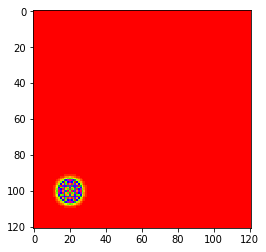

time= 25.0
min/max= -0.245488345688 0.236825049851


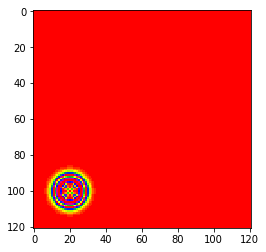

time= 50.0
min/max= -0.154033365164 0.182633481829


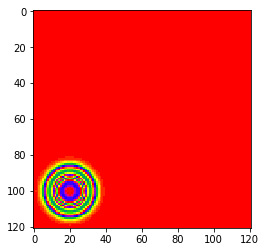

time= 75.0
min/max= -0.10569862376 0.153407032713


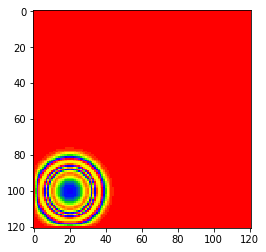

time= 100.0
min/max= -0.144224202634 0.134552960331


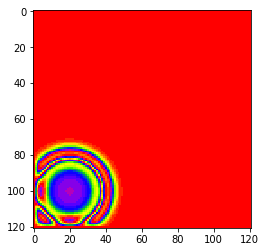

time= 125.0
min/max= -0.199506702817 0.121023330873


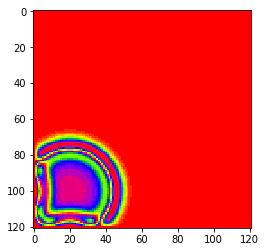

time= 150.0
min/max= -0.229575071116 0.110714884067


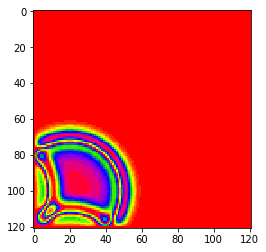

time= 175.0
min/max= -0.200784801505 0.210984031467


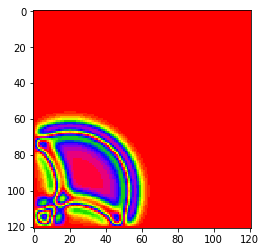

time= 200.0
min/max= -0.18540362708 0.161917720306


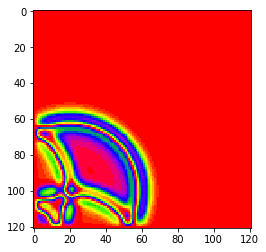

time= 225.0
min/max= -0.17137942871 0.147693346001


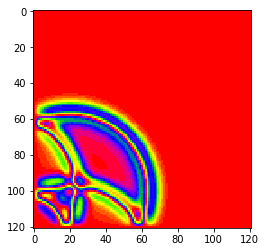

time= 250.0
min/max= -0.1642498645 0.141003971065


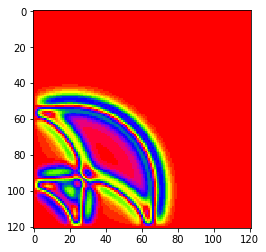

In [27]:
sets = np.unique(file_data[:,0])
width = 8
height = 4
print("sets=",sets)
mn, mx = np.min(file_data[:,12]),np.max(file_data[:,12])
#mn, mx = 0,1
for which in sets:
    g = file_data[file_data[:,0]==which,:]
    print("time=",which)
    x = g[:,5]
    y = g[:,6]
    z = g[:,12]
    zi = z.reshape(len(np.unique(y)),len(np.unique(x)))
    print('min/max=',np.min(zi),np.max(zi))
    plt.figure(figsize=(width, height))
    plt.imshow(zi[::-1,:],cmap,clim=(mn,mx))
    plt.show()

<h3>Exercises:</h3>
<ol>
<li>Add a parameter to param.ccl and use it to change the position of the Gaussian wave hump.</li>
<li>Advanced: Write a Conway's Game of Life thorn. For this thorn it does not make sense to use MoL. Schedule your routine in CCTK_EVOL.</li>
</ol>

<h2>Adaptive Mesh Refinement</h2>
Sometimes you care more about what is happening in one part of a grid than another. Wouldn't it be nice if you could
spend less time computing in regions that are less important? That way you could explore larger problems with less compute cycles.

Well, dream no more. Adaptive Mesh Refinement is supported in Cactus/Carpet. And, at least for the toy example we are
considering in this file, all you have to change to make use of it is your parameter file. (Actually, what we're going
to consider here is technically Fixed Mesh Refinement (FMR)).

<h3>How AMR works</h3>
For reasons of simplicity, we'll focus on a 2 refinement level system. Thus, we have a coarse (refinement level 0) and a fine level (refinement level 1). We start from a time t0, at which data on all refinement levels is consistent and valid.

* All data is initialized at time t = t0
* The coarse level is evolved forward to time to t = t0 + dt
* The fine level is evolved forward to time to t = t0 + dt/2
* Boundary data for the fine grid at time to t = t0+dt/2 is interpolated from the coarse grids at times t0 and t0+dt
* The fine level is evolved forward in time to t = t0 + dt
* Data from the fine level at t=t0+dt is copied back into the coarse grid at time t=t0+dt
* If not done, t0 += dt and repeat.

In [32]:
wave_toy2_par_src = """
ActiveThorns = "{thorn_name} coordbase carpet cartgrid3d MoL"

Cactus::cctk_itlast = 250

# the output dir will be named after the parameter file name
IO::out_dir = $parfile

# The set of parameters required to specify the grid...
Carpet::domain_from_coordbase = "yes"
CartGrid3D::type = "coordbase"
CartGrid3D::avoid_origin = "no"
CoordBase::domainsize = "minmax"
CoordBase::spacing    = "gridspacing"
CoordBase::xmin =  0
CoordBase::xmax =  30
CoordBase::ymin =  0
CoordBase::ymax =  30
CoordBase::zmin =  0.0
CoordBase::zmax =  0.0
CoordBase::dx   =  0.25
CoordBase::dy   =  0.25

# Because we're doing a 2D code...
CoordBase::boundary_size_z_lower     = 0
CoordBase::boundary_size_z_upper     = 0
CoordBase::boundary_shiftout_z_lower = 1
CoordBase::boundary_shiftout_z_upper = 1

# The time integration scheme...
MoL::ODE_Method = "RK3"

# The next section is required if you want some kind of confirmation
# on the console that your code is actually doing anything...
ActiveThorns = "CarpetIOBasic IOUtil CarpetReduce SymBase"
IO::out_fileinfo="all"
IOBasic::outInfo_every = 1
IOBasic::outInfo_vars = "{thorn_name}::phi {thorn_name}::psi"

# Get some data!
ActiveThorns = "CarpetIOASCII"
CarpetIOASCII::compact_format = false
IOASCII::out2D_every = 25
IOASCII::out2D_xyplane_z = 0
IOASCII::out2D_vars = "{thorn_name}::psi {thorn_name}::phi"
IOASCII::out2D_xz = "no"
IOASCII::out2D_yz = "no"
IOASCII::output_ghost_points = "no"

# Taking too big a time step can lead to unstable evolution.
# You can control that with dtfac and thorn Time.
ActiveThorns = "Time"
Time::dtfac = .2

### MESH REFINEMENT ####
ActiveThorns = "CarpetRegrid2"
Carpet::init_fill_timelevels = "true"
Carpet::max_refinement_levels = 2
CarpetRegrid2::num_centres = 1
CarpetRegrid2::num_levels_1 = 2
CarpetRegrid2::position_x_1 = 8.0
CarpetRegrid2::position_y_1 = 8.0
CarpetRegrid2::position_z_1 = 0.0
CarpetRegrid2::radius_1[1] = 8.0

#MoL::disable_prolongation        = "no"

### Dissipation is numerical noise added to mitigate
### grid boundary effects seen in some AMR simulations.
#ActiveThorns = "Dissipation Spacemask SPHERICALSURFACE"
#Dissipation::vars = "{thorn_name}::psi {thorn_name}::phi"
#Dissipation::order = 1
"""
create_file("wave_toy2.par",wave_toy2_par_src,thorn_pars)

Over-writing file 'wave_toy2.par'


In [33]:
!rm -fr ../simulations/wave_toy2
!./simfactory/bin/sim create-run wave_toy2.par --procs=2 --num-threads=1

Parameter file: /home/sbrandt/CactusFW2/wave_toy2.par
Skeleton Created
Job directory: "/home/sbrandt/simulations/wave_toy2"
Executable: "/home/sbrandt/CactusFW2/exe/cactus_sim"
Option list: "/home/sbrandt/simulations/wave_toy2/SIMFACTORY/cfg/OptionList"
Submit script: "/home/sbrandt/simulations/wave_toy2/SIMFACTORY/run/SubmitScript"
Run script: "/home/sbrandt/simulations/wave_toy2/SIMFACTORY/run/RunScript"
Parameter file: "/home/sbrandt/simulations/wave_toy2/SIMFACTORY/par/wave_toy2.par"
Simulation name: wave_toy2
Assigned restart id: 0 
Running simulation wave_toy2
Preparing:
+ set -e
+ echo Checking:
Checking:
+ pwd
/home/sbrandt/simulations/wave_toy2/output-0000
+ hostname
melete05.cct.lsu.edu
+ date
Mon Jul 31 13:09:26 CDT 2017
+ echo Environment:
Environment:
+ export CACTUS_NUM_PROCS=2
+ CACTUS_NUM_PROCS=2
+ export CACTUS_NUM_THREADS=1
+ CACTUS_NUM_THREADS=1
+ export GMON_OUT_PREFIX=gmon.out
+ GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=1
+ OMP_NUM_THREADS=1
+ echo Starting

INFO (CycleClock): Calibrated CycleClock: 0.454547 ns per clock tick (2.19999 GHz)
INFO (Vectors): Using vector size 1 for architecture scalar (no vectorisation, 64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
MoL: Generalized time integration.
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 2D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 3D ASCII I/O pro

       14     0.350 |    0.0000000    0.7755426 |   -1.1810500    0.1607963
       15     0.375 |    0.0000000    0.7453294 |   -1.2350787    0.1686087
       16     0.400 |    0.0000000    0.7138342 |   -1.2835910    0.1756801
       17     0.425 |    0.0000000    0.6811967 |   -1.3264526    0.1819682
       18     0.450 |    0.0000000    0.6475593 |   -1.3635660    0.1875357
       19     0.475 |    0.0000000    0.6130666 |   -1.3948707    0.1925037
---------------------------------------------------------------------------
Iteration      Time |          WAVETOYET17::psi |          WAVETOYET17::phi
                    |      minimum      maximum |      minimum      maximum
---------------------------------------------------------------------------
       20     0.500 |    0.0000000    0.5778643 |   -1.4203425    0.1968608
       21     0.525 |    0.0000000    0.5420980 |   -1.4399933    0.2006060
       22     0.550 |    0.0000000    0.5059128 |   -1.4538701    0.2037830
       23   

      113     2.825 |   -0.1312122    0.1728183 |   -0.3100714    0.1514331
      114     2.850 |   -0.1301249    0.1721798 |   -0.3084894    0.1511242
      115     2.875 |   -0.1289651    0.1714354 |   -0.3067029    0.1504933
      116     2.900 |   -0.1278400    0.1707783 |   -0.3051748    0.1498728
      117     2.925 |   -0.1267905    0.1703357 |   -0.3041346    0.1496714
      118     2.950 |   -0.1257015    0.1696310 |   -0.3024357    0.1491474
      119     2.975 |   -0.1246658    0.1689289 |   -0.3008001    0.1485438
---------------------------------------------------------------------------
Iteration      Time |          WAVETOYET17::psi |          WAVETOYET17::phi
                    |      minimum      maximum |      minimum      maximum
---------------------------------------------------------------------------
      120     3.000 |   -0.1236720    0.1684845 |   -0.2998056    0.1481003
      121     3.025 |   -0.1226981    0.1678965 |   -0.2983763    0.1478410
      122   

      201     5.025 |   -0.1564429    0.1342974 |   -0.3427062    0.1205620
      202     5.050 |   -0.1617221    0.1340044 |   -0.3417787    0.1205310
      203     5.075 |   -0.1667188    0.1336532 |   -0.3416054    0.1201862
      204     5.100 |   -0.1714252    0.1333065 |   -0.3406210    0.1198340
      205     5.125 |   -0.1763418    0.1331339 |   -0.3404688    0.1196989
      206     5.150 |   -0.1808853    0.1327871 |   -0.3393181    0.1195071
      207     5.175 |   -0.1850455    0.1324514 |   -0.3392875    0.1191464
      208     5.200 |   -0.1888135    0.1322176 |   -0.3382412    0.1187993
      209     5.225 |   -0.1921817    0.1319493 |   -0.3380266    0.1187952
      210     5.250 |   -0.1951438    0.1316120 |   -0.3371976    0.1184769
      211     5.275 |   -0.1976949    0.1312802 |   -0.3366306    0.1181325
      212     5.300 |   -0.1998313    0.1311142 |   -0.3361174    0.1179807
      213     5.325 |   -0.2015507    0.1307836 |   -0.3350319    0.1178233
      214   

In [34]:
file_data = np.genfromtxt("../simulations/wave_toy2/output-0000/wave_toy2/psi.xy.asc")

sets= [   0.   25.   50.   75.  100.  125.  150.  175.  200.  225.  250.]
time= 0.0
refinement level = 0


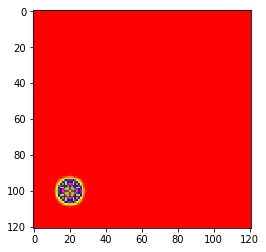

refinement level = 1


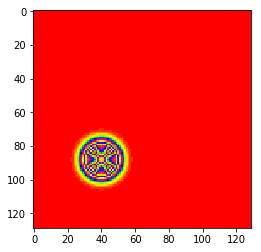

time= 25.0
refinement level = 1


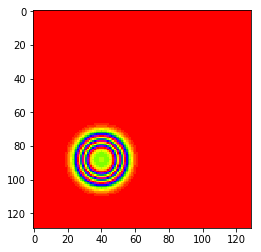

time= 50.0
refinement level = 0


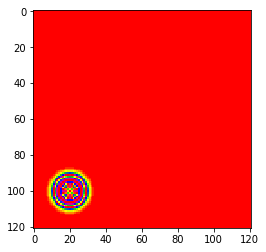

refinement level = 1


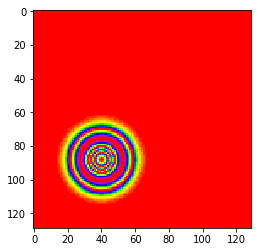

time= 75.0
refinement level = 1


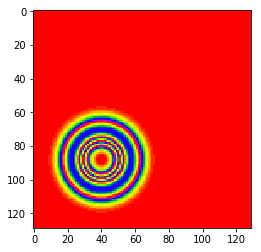

time= 100.0
refinement level = 0


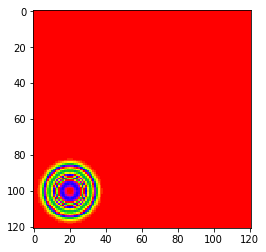

refinement level = 1


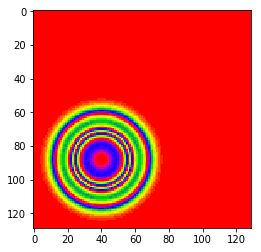

time= 125.0
refinement level = 1


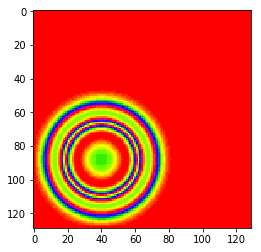

time= 150.0
refinement level = 0


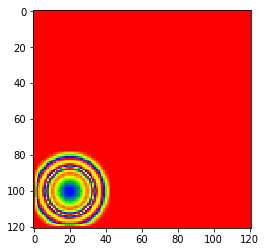

refinement level = 1


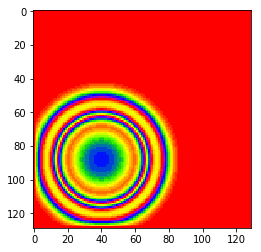

time= 175.0
refinement level = 1


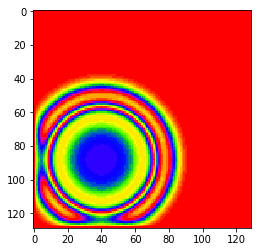

time= 200.0
refinement level = 0


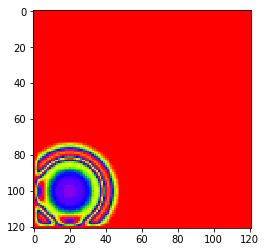

refinement level = 1


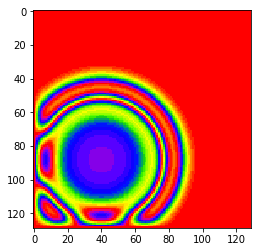

time= 225.0
refinement level = 1


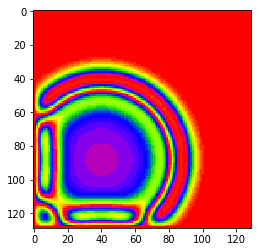

time= 250.0
refinement level = 0


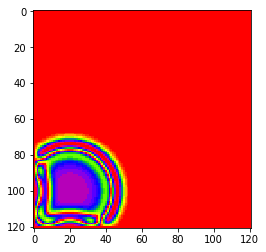

refinement level = 1


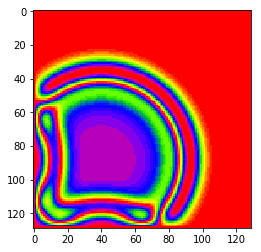

In [35]:
sets = np.unique(file_data[:,0])
width = 8
height = 4
# NOTE: I changed the colorscheme here
cmap = cm.prism
print("sets=",sets)

mn, mx = np.min(file_data[:,12]),np.max(file_data[:,12])
#mn, mx = 0,1
for which in sets:
    gg = file_data[file_data[:,0]==which,:]
    print("time=",which)
    for rl in range(10): # refinement levels
      g = gg[gg[:,2]==rl,:]
      x = g[:,5]
      y = g[:,6]
      z = g[:,12]
      if z.shape[0] == 0:
        continue
      print("refinement level =",rl)
      plt.figure(figsize=(width, height))
      zi = z.reshape(len(np.unique(y)),len(np.unique(x)))
      plt.imshow(zi[::-1,:],cmap,clim=(mn,mx))
      plt.show()

<h3>Excercise:</h3> Play around with the CarpetRegrid2 parameters. Attempt to add more levels of refinement and/or more centers of refinement.

<table><tr><td>This work sponsored by NSF grants <a href="https://www.nsf.gov/awardsearch/showAward?AWD_ID=1550551"> OAC 1550551</a> and <a href="https://www.nsf.gov/awardsearch/showAward?AWD_ID=1539567"> CCF 1539567</a></td><td><img src="https://www.nsf.gov/awardsearch/images/common/nsf_logo_bottom.png"></tr></table>